In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from models import MLP
from data import load_2d_sample, load_gaussian_sample

In [2]:
class Buffer:
    def __init__(self, buffer_size = None, axis = 1):
        self.buffer = None
        self.buffer_size = buffer_size
        self.axis = axis
        
    def store(self, sample):
        if self.buffer is None:
            self.buffer = sample
        else:
            self.buffer = torch.cat([self.buffer, sample], dim = self.axis)
            
        if self.buffer_size is not None:
            current_buffer_size = self.buffer.shape[self.axis]
            if current_buffer_size > self.buffer_size:
                self.buffer = torch.narrow(self.buffer, dim=self.axis, start=current_buffer_size-buffer_size, length=buffer_size)
                
    def sample(self, batch_size):
        indices = np.random.choice(self.buffer.shape[self.axis], size = (batch_size,), replace = False)
        indices = torch.Tensor(indices).long().cuda()
        return torch.index_select(self.buffer, self.axis, indices)

In [3]:
def dsb_forward_rollout(encoder, data_sample, time_steps, step_size, data_t_embeddings = None, apply_encoder = True):
    
    if data_t_embeddings is None:
        num_data = data_sample.shape[0]
        t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
        data_t_embeddings = torch.repeat_interleave(t_embeddings, num_data, dim = 1)
    
    data_cache = []
    data_at_t = data_sample
    data_cache.append(data_at_t)
    for t in range(time_steps-1):
        if apply_encoder:
            data_at_t  = encoder(data_at_t, data_t_embeddings[t])
        else:
            data_at_t = data_at_t * (1 - step_size)
        data_at_t = data_at_t + np.sqrt(2*step_size) * torch.randn(*data_at_t.shape).cuda()
        data_cache.append(data_at_t)
        
    data_cache = torch.stack(data_cache, dim = 0)
    
    return data_cache

def dsb_backward_rollout(decoder, prior_sample, time_steps, step_size, prior_t_embeddings = None):
    
    if prior_t_embeddings is None:
        num_prior = prior_sample.shape[0]
        t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
        prior_t_embeddings = torch.repeat_interleave(t_embeddings, num_prior, dim = 1)
    
    prior_cache = []
    prior_at_t = prior_sample
    prior_cache.append(prior_at_t)
    for t in reversed(range(1, time_steps)):
        prior_at_t  = decoder(prior_at_t, prior_t_embeddings[t])
        prior_at_t = prior_at_t + np.sqrt(2*step_size) * torch.randn(*prior_at_t.shape).cuda()
        prior_cache.append(prior_at_t)
        
    prior_cache = prior_cache[::-1]
        
    prior_cache = torch.stack(prior_cache, dim = 0)
    
    return prior_cache

def dsb_train_decoder_one_step(
    encoder, decoder, 
    decoder_opt, 
    data_cache, 
    time_steps, step_size, 
    apply_encoder = True, 
):
    # sample shape: (batch, ...)
    
    num_data = data_cache.shape[1]
    
    t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
    
    data_t_embeddings = torch.repeat_interleave(t_embeddings, num_data, dim=1)
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    ### Training decoder (forward function)
    
    if apply_encoder:
        diff = decoder(data_cache[1:], data_t_embeddings[1:]) - (data_cache[1:] + encoder(data_cache[:-1], data_t_embeddings[:-1]) - encoder(data_cache[1:], data_t_embeddings[:-1]))
    else:
        diff = decoder(data_cache[1:-1], data_t_embeddings[1:-1]) - (data_cache[1:-1] + data_cache[1:-1] - data_cache[2:])
    decoder_loss = torch.square(diff).mean()
    
    decoder_loss.backward()
    # torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
    decoder_opt.step()
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    return decoder_loss.detach().cpu().numpy().item()

def dsb_train_encoder_one_step(
    encoder, decoder, 
    encoder_opt, 
    prior_cache, 
    time_steps, step_size, 
    bootstrap = True, 
):
    # sample shape: (batch, ...)
    
    num_prior = prior_cache.shape[1]
    
    t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
    
    prior_t_embeddings = torch.repeat_interleave(t_embeddings, num_prior, dim=1)
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    ### Training encoder (backward function)

    diff = encoder(prior_cache[:-1], prior_t_embeddings[:-1]) - (prior_cache[:-1] + decoder(prior_cache[1:], prior_t_embeddings[1:]) - decoder(prior_cache[:-1], prior_t_embeddings[1:]))
    encoder_loss = torch.square(diff).mean()
    
    encoder_loss.backward()
    # torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
    encoder_opt.step()
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    return encoder_loss.detach().cpu().numpy().item()

In [4]:
### Hyperparameters

# epochs = 10 # for others
epochs = 20 # for Gaussian
iters_per_epoch = 2_000
time_steps = 20

buffer_update_size = 4096
buffer_update_freq = 20

buffer_size = 10_000

batch_size = 512

lr = 1e-4

step_size = 1e-3

### Dataloader functions

data_name = "swiss_roll"
prior_name = "gaussian"

### Initialize model

encoder = MLP(2, 1, 64, 4, step_size = 1)
decoder = MLP(2, 1, 64, 4, step_size = 1)

encoder.cuda()
decoder.cuda()

encoder_opt = optim.Adam(encoder.parameters(), lr=lr)
decoder_opt = optim.Adam(decoder.parameters(), lr=lr)

### Initiate training

pbar = tqdm(total = epochs, position=0, leave=True)

history = []
model_cache = []

train_log = {"decoder_loss": np.nan, "encoder_loss": np.nan}

for epoch in range(epochs):
    
    ### Train decoder until convergence
    buffer = Buffer(buffer_size = buffer_size, axis = 1)
    for ii in range(iters_per_epoch):
        if ii % buffer_update_freq == 0:
            with torch.no_grad():
                data_sample = load_2d_sample(buffer_update_size, name = data_name).cuda()
                _data_cache = dsb_forward_rollout(encoder, data_sample, time_steps, step_size)
                buffer.store(_data_cache)
        data_cache = buffer.sample(batch_size)
        decoder_loss = dsb_train_decoder_one_step(
            encoder, decoder, 
            decoder_opt, 
            data_cache, 
            time_steps, step_size, 
            apply_encoder = (epoch != 0), # apply Langevin encoding process in the first iteration
        )
        train_log = {"decoder_loss": decoder_loss, "encoder_loss": np.nan}
        history.append(train_log)
        pbar.set_postfix(train_log)
    
    ### Train encoder until convergence
    buffer = Buffer(buffer_size = buffer_size, axis = 1)
    for ii in range(iters_per_epoch):
        if ii % buffer_update_freq == 0:
            with torch.no_grad():
                prior_sample = load_2d_sample(buffer_update_size, name = prior_name).cuda()
                _prior_cache = dsb_backward_rollout(decoder, prior_sample, time_steps, step_size)
                buffer.store(_prior_cache)
        prior_cache = buffer.sample(batch_size)
        encoder_loss = dsb_train_encoder_one_step(
            encoder, decoder, 
            encoder_opt, 
            prior_cache, 
            time_steps, step_size, 
        )
        train_log = {"decoder_loss": np.nan, "encoder_loss": encoder_loss}
        history.append(train_log)
        pbar.set_postfix(train_log)
        
    model_cache.append((encoder, decoder))
    
    pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

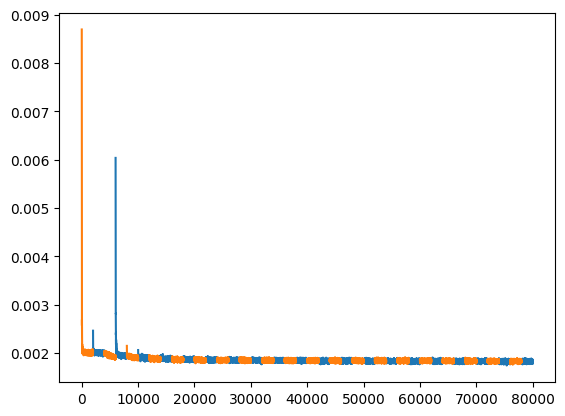

In [5]:
history_df = pd.DataFrame(history)

plt.plot(history_df["encoder_loss"])
plt.plot(history_df["decoder_loss"])

plt.show()

In [6]:
### evaluation rollout

viz_batch_size = 1024
num_batch = 1

cache = []

for ii in tqdm(range(num_batch)):
    prior_sample = load_2d_sample(viz_batch_size, name = prior_name).cuda()

    dsb_sample = dsb_backward_rollout(decoder, prior_sample, time_steps, step_size).detach().cpu().numpy()
    
    cache.append(dsb_sample)

cache = np.concatenate(cache, axis = 1)

  0%|          | 0/1 [00:00<?, ?it/s]

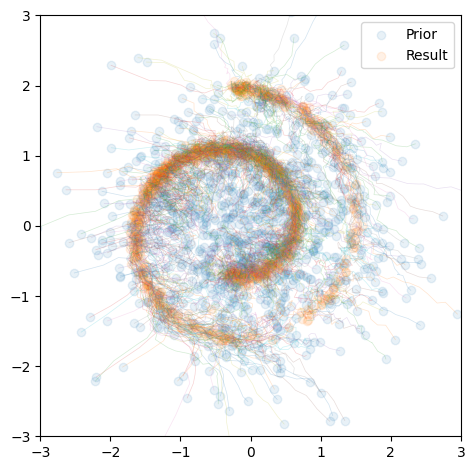

In [7]:
### Hyperparameters for plotting

num_viz_path = 1024

line_alpha = 0.2
scatter_alpha = 0.1

linewidth = 0.5

plot_dir = "plots"

### Plotting

for ii in np.random.choice(cache.shape[1], num_viz_path, replace = False):
    traj = cache[:, ii]
    plt.plot(traj[:, 0], traj[:, 1], linewidth = linewidth, alpha = line_alpha)

plt.scatter(cache[-1, :, 0], cache[-1, :, 1], alpha = scatter_alpha, label = "Prior")
plt.scatter(cache[0, :, 0], cache[0, :, 1], alpha = scatter_alpha, label = "Result")

plt.legend()

plt.axis('scaled')

plt.xlim([-3, 3])
plt.ylim([-3, 3])

plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "DSB_traj_{}_{}".format(prior_name, data_name)), dpi = 200, bbox_inches='tight', pad_inches=0)

plt.show()

In [8]:
diff = cache[1:] - cache[:-1]
distance = np.sqrt(np.square(diff).sum(axis = -1))
traj_distance = distance.sum(axis = 0)

print("Mean distance of trajectory:", traj_distance.mean())

Mean distance of trajectory: 1.4426835


In [9]:
# from datetime import datetime

# now = datetime.now()
# hour = now.hour
# minute = now.minute

# torch.save([(e.state_dict(), d.state_dict()) for (e,d) in model_cache], "dsb_models_{}{}.pt".format(hour, minute))